<font size=5  color=#003366> [LELEC2885] - Image Processing <br><br> 
TP 1 : The convolution & The Laplacian Pyramid </font> <br><br><br>

<font size=5  color=#003366>
Prof. L. Jacques <br>
Prof. C. De Vleeschouwer 
<br><br>
Benoit Brummer (benoit.brummer@uclouvain.be) <br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
Olivier Leblanc (o.leblanc@uclouvain.be) <br>
Gabriel Van Zandycke (gabriel.vanzandycke@uclouvain.be) <br>
<div style="text-align: right"> 2021-2022 </div>
<br><br>
</font>

<br>

<font size=6 color=#009999> BEFORE STARTING </font> <br><br>

Python packages can be installed from within the notebooks as well. By running the following cell, you will install the Numpy, PyWavelets, Imageio, Matplotlib and Scipy libraries. 

The documentation can be easily found on the internet. Never hesitate to have a look at it!

In [2]:
# Dependencies for this notebook
!pip3 install numpy imageio matplotlib scipy

In [3]:
# Required imports
import numpy as np
import scipy.signal as sig
from matplotlib import pyplot as plt
import imageio

<br>

<font size=6 color=#009999> THE CONVOLUTION </font> <br>

<br>
<font size=5 color=#009999> 1.1  Straightforward ("naive") convolution implementation </font> <br>

Define the convolution operation of an $N \times N$ image $f$ with a $k \times k$ kernel $h$ as

$$ (f * h)(i,j) = \sum_{i'=1}^{K} \sum_{j'=1}^K f(i-i',j-j') h(i',j') \quad \forall i,j = 1, ..., N.$$

**Question:** complete the function below which performs the convolution operation (you should read the `scipy.signal` documentation).

Do not test it just yet, we will do that in a little while.

In [4]:
def naive_convolution(image, kernel):
    """The convolution2d function offered with the library scipy.signal has a naive implementation.
    Please use it here to provide a first naive convolution function that conserves image size.
    """
    # Write your implementation here
    kernel = kernel / np.sum(kernel)   # Normalization of the kernel
    result = sig.convolve2d(image,kernel, mode='same', boundary="wrap")   # Convolution 2D image * kernel
    
    return result

<br>
<font size=5 color=#009999> 1.2  Faster implementation </font> <br>

This "straightforward" (one might say, "naive") implementation of the convolution of the $N \times N$ signal $f$ with the $k \times k$ kernel $h$ has complexity $\mathcal{O}(N^2k^2)$, which becomes prohibitive when $k$ is of the order of $N$. Fortunately, a convolution in spatial domain is equivalent to an element-wise multiplication in the Fourier domain ($\odot$ denotes the Hadamard (element-wise) product):

$$f * h = \mathcal{F^{-1}} ( \mathcal{F f} \odot \mathcal{F h} ).$$

<div class="alert alert-block alert-warning">
<b> Computational complextity of the FFT </b> <br>
Computing the convolution this way should bring a large speedup, since the Fast Fourier Transform of an $N \times N$ image has an algorithmic complexity of $\mathcal{O}(N^2\log N^2)$ (we assume for simplicity that $N$ is a power of $2$).
</div>

<div class="alert alert-block alert-info">
<b> Do not reinvent the wheel: Read The Fucking Manual ([RTFM](http://www.readthefuckingmanual.com/))! </b><br> 
When coding a process, there may be a temptation to implement everything from scratch. However, Python is offering a huge amount of functions that will make your code much easier and readable! Let's have a look at the next cell and especially at lines 11 & 12. Of course, you can rewrite this procedure by yourself, but isn't it esier with the `pad` and `roll` functions?
<br>
   
</div>

**Question:** Can you complete the following code implementing convolution in the Fourier domain?

In [5]:
def resize_and_fix_origin(kernel, size):
    """Pads a kernel to reach shape `size`, and shift it in order to cancel phase.
    This is based on the assumption that the kernel is centered in image space.
    A note about this is provided in section 1.4. 
    """
    # Very specific routine... You don't have to understand it
    pad0, pad1 = size[0]-kernel.shape[0], size[1]-kernel.shape[1]
    # shift less if kernel is even, to start with 2 central items
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2

    kernel = np.pad(kernel, ((0,pad0), (0,pad1)), mode='constant')
    kernel = np.roll(kernel, (-shift0, -shift1), axis=(0,1))
    return kernel


def fast_convolution(image, kernel):
    """The library numpy.fft offers functions to implement the fast fourrier transform.
    Please implement a fast convolution algorithm using it.
    
    Be careful! In order to be multiplied elementwise, the Fourier representations have to
    be the same size. Furthermore, a centered kernel will introduce a phase in the Fourier
    domain, which introduces a shift in the final result.
    
    In order to cope with those two problems, you can call resize_and_fix_origin defined
    above
    """
    # Write your implementation here
    image_fft = np.fft.fft2(image)    # 2D Fourier transform of the image
    kernel_fixed = resize_and_fix_origin(kernel, image.shape)   # Padding of the of the kernel
    kernel_fft = np.fft.fft2(kernel_fixed)    # 2D Fourier transform of the kernel
    product = image_fft * kernel_fft    # Convolution of the image and the kernel
    
    result = np.fft.ifft2(product).real    # Inverse Fourier transform to obtain the result
    
    
    return result

<br>
<font size=5 color=#009999> 1.3  Comparison between the two methods </font> <br>

First, let us load an image that will serve as running example for this notebook, using the method we learned in the previous notebook.

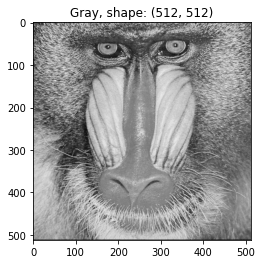

In [6]:
baboon_gray = imageio.imread("images/baboon.png", pilmode="L")

plt.title("Gray, shape: {}".format(baboon_gray.shape))
plt.imshow(baboon_gray, cmap="gray")  # Use the gray color map
plt.show()

To be able to try these functions out, let us first initialize some gaussian kernel. This is also an opportunity to see how `resize_and_fix_origin` actually "fixes the origin" of the kernel.

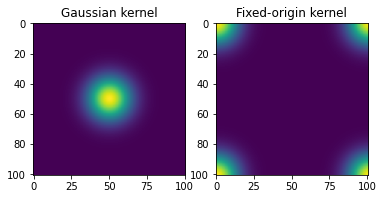

In [7]:
def gaussian_kernel(sigma,n):
    """Returns a n-by-n gaussian kernel (point spread function) with scale sigma.
    Centered when shift=False."""
    indices = np.linspace(-n/2,n/2,n)
    [X,Y]   = np.meshgrid(indices,indices)
    h       = np.exp( -(X**2+Y**2)/(2.0*(sigma)**2) )
    h      /= h.sum() # Normalize
    return h

kernel = gaussian_kernel(10, 101)  # Small kernel for naive convolution
plt.subplot(121, title="Gaussian kernel")
plt.imshow(kernel)
plt.subplot(122, title="Fixed-origin kernel")
plt.imshow(resize_and_fix_origin(kernel, kernel.shape))
plt.show()

After having implemented the fast and naive convolutions, the following cell should show blurry versions of the baboon image.

Do you observe any difference in terms of running time between the two implementations ?

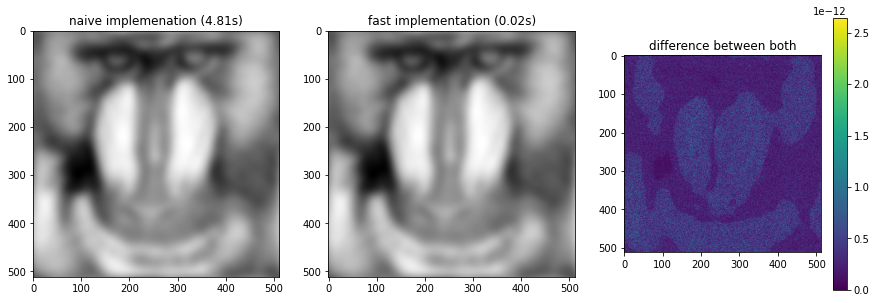

In [8]:
import time
import copy
tic = time.time()
naive_result = naive_convolution(copy.deepcopy(baboon_gray), copy.deepcopy(kernel))
tac = time.time()
fast_result = fast_convolution(copy.deepcopy(baboon_gray), copy.deepcopy(kernel))
toc = time.time()

plt.figure(figsize=(15,5))
plt.subplot(131, title="naive implemenation ({0:.2f}s)".format(tac-tic))
plt.imshow(naive_result, cmap="gray")
plt.subplot(132, title="fast implementation ({0:.2f}s)".format(toc-tac))
plt.imshow(fast_result, cmap="gray")
plt.subplot(133, title="difference between both")
plt.imshow(np.abs(naive_result-fast_result))
plt.colorbar()
plt.show()

Do you achieve similar results using both algorithms ? What about the timing ?

* Very small differences in the results
* Huge time difference

<br>
<font size=5 color=#009999> 1.4  Supplementary note: Why do we shift and/or pad the kernel in 1.2? </font> <br>



C:\Users\nilsb\OneDrive - UCL\Documents\LELEC2885 - Image processing and computer vision\TP\TP0 + TP1\TP4_utils.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  mpl.cm.get_cmap().set_bad(color='red')


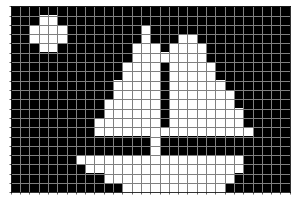

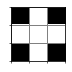

In [9]:
from TP4_utils import display_pixels

# Let's have a binary image
image = 1-(imageio.imread("images/boat.png") > 128).astype(np.uint8)
display_pixels(plt.figure(figsize=(5,5)).gca(), image)
# ... and a binary kernel
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
display_pixels(plt.figure(figsize=(1,1)).gca(), kernel)

To convolve an image with a kernel using FFT, the kernel needs to be padded with 0s to reach the image size. Take the time to understand when we pad or when we shift with the 4 following methods.

<img src='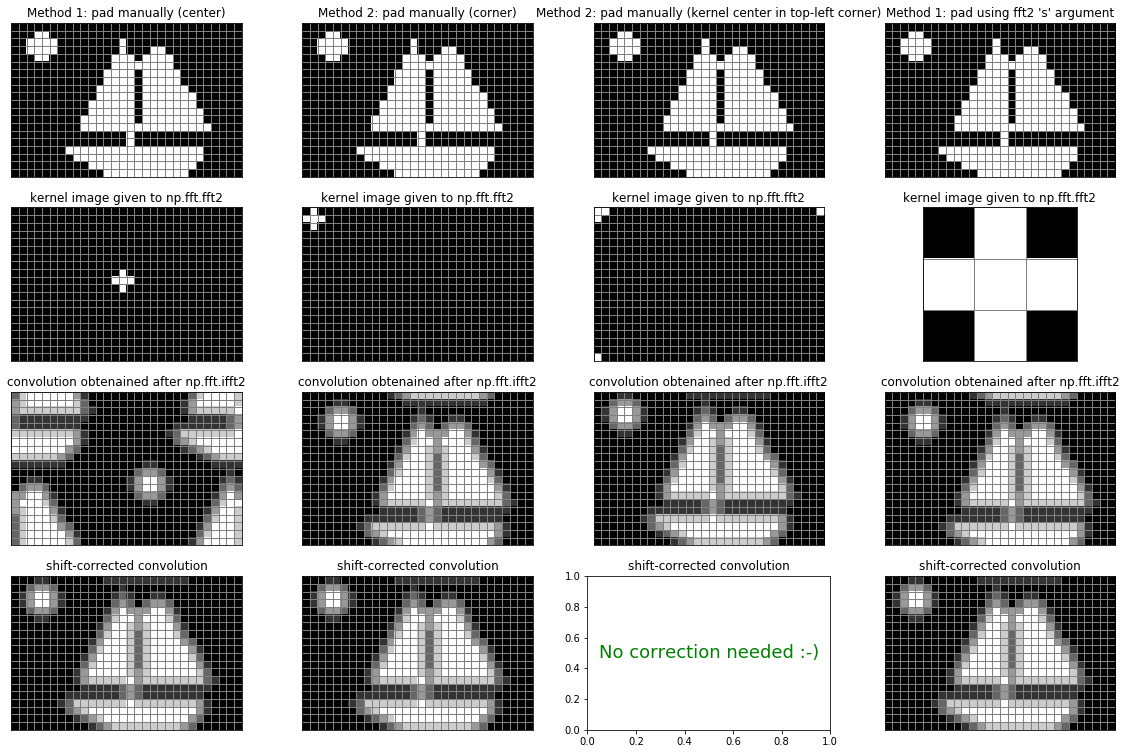
' />

<br>

<font size=6 color=#009999> A MULTI-SCALE REPRESENTATION: THE LAPLACIAN PYRAMID </font> <br>

<br>
<font size=5 color=#009999> 2.1 A brief reminder... </font> <br>

One of the advantages of the Fourier representation of an image is that it allows to easily separate the low-frequency content, i.e., the "smooth content" of the image, from the high-frequency content, i.e., the "details" of the image. However, in the Fourier representation all the spatial information is "mixed up", making it hard for instance to localize objects.

In image processing, we often desire a representation that achieves a tradeoff between accurate frequency and spatial localization. This is the rationale behind time-frequency representations of images: the most basic example of those is the **Laplacian Pyramid Representation**.

<br>
<font size=5 color=#009999> 2.2 Implement a Lapacian Pyramid </font> <br>

The idea is quite simple:

1. Start with $i=0$ and your image at full resolution $I_0$  ($i$ denotes the resolution index).
1. Blur $I_i$ with a gaussian kernel to obtain $B_i$, the blurred image at level $i$.
1. Downsample $B_i$ to obtain $I_{i+1}$, the image at one lower resolution level (without *aliasing* thanks to the blur).
1. *Expand* $I_{i+1}$ back to the resolution $i$ to obtain $I'_{i+1}$, *i.e.,* by zero-padding in the frequency domain.
1. Store the difference $D_i = I_i-I'_{i+1}$. We say that $D_i$ contains the *details* at resolution $i$.
1. Start over at step 2 with $i\gets i+1$ until the resolution level $i$ is "coarse" enough. At the last step $i_{\max}$, also store the coarsest image $I_{i_{\max}}.$ 

This way, when you look at $D_i$, you are able to analyze the *spatial* content of the image at a given *resolution* $i$: the smallest (resp. largest) value of $i$ corresponds to the highest (resp. lowest) frequency content. Let's look at it in practice to understand what's going on.

<img src="images/LaplacianPyramid.png" width = "450">


**Question:** Can you complete the following code ?

<div class="alert alert-block alert-info">
<b> How to ... in python? </b><br> 
Python offers many shortcuts to perform operations in a single line. Did you want to use nested loop to implement the downSampling operation? It will work, but could you find a less verbose method that stands in only 1 line? <br> 
<i> Hint: We use it during TP0... </i>
<br>

In [10]:
def blur(I_i):
    """Blurs the image I_i for the Laplacian pyramid algorithm."""
    kernel = gaussian_kernel(1, I_i.shape[0])    # We creat our Gaussian kernel
    B_i = fast_convolution(I_i, kernel) # TO COMPLETE
    # Hint: you should use the answer to section 1.2 and the Gaussian filter function we provided
    
    return B_i

def downSample(B_i):
    """Downsamples the image B_i by keeping one pixel out of two samples in each direction).
    This is called 2x2 data binning."""
    # We keep one pixel on 2
    I_iplus1 = B_i[0::2,0::2] # TO COMPLETE 

    return I_iplus1

def expand(I_iplus1):
    """Upsamples (interpolate on twice the size) I_iplus1 by zero-padding it in the frequency domain."""
    image_fft = np.fft.fftshift(np.fft.fft2(I_iplus1))    # We shift the image before padding
    padded_fft = np.pad(image_fft, (I_iplus1.shape[0]//2, I_iplus1.shape[1]//2), 'constant')    # Zero padding
    
    Iprime_iplus1 = 4 * np.abs(np.fft.ifft2(np.fft.fftshift(padded_fft))) # The 4 is from the fact we loose a
    # factor 4 in intensity (due to the zero padding)
    
    return Iprime_iplus1

**Question:** Can you use the previously written functions to compute the decomposition of the baboon image?

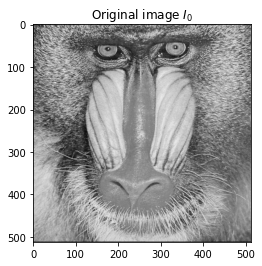

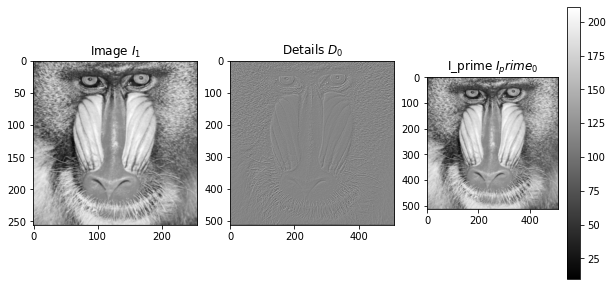

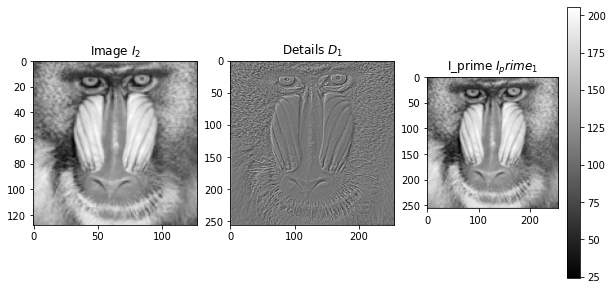

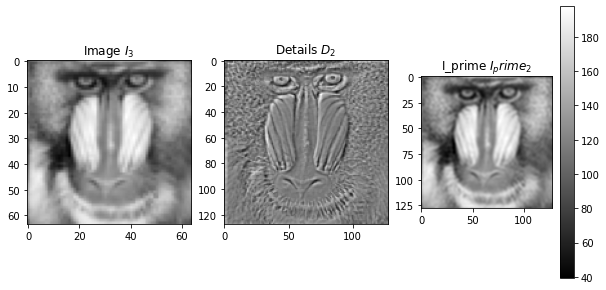

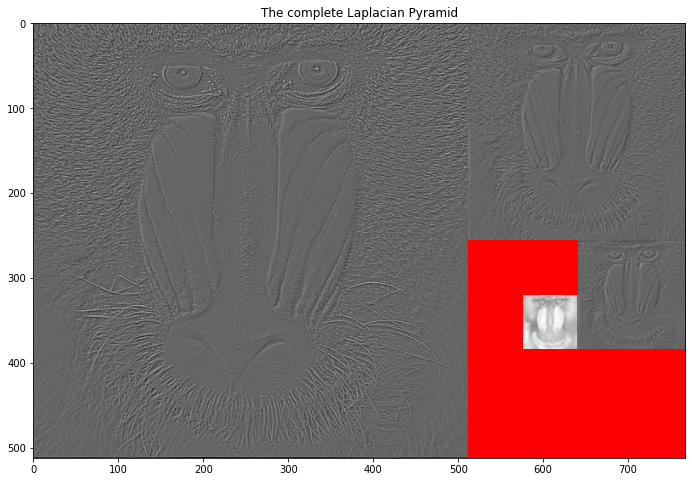

In [15]:
from TP1_utils import plot_pyramid
# Build a Laplacian pyramid
I_0 = baboon_gray # Some test image here

# Initialization
I_i   = I_0 
i_max = 3

plt.imshow(I_i,cmap='gray')
plt.title(r'Original image $I_0$')
plt.show()

pyramid = []

# Build the Pyramid
for i in range(i_max):
    # TO COMPLETE  
    B_i = blur(I_i)
    I_iplus1 = downSample(B_i)
    Iprime_iplus1 = expand(I_iplus1)
    D_i = I_i - Iprime_iplus1
    
    
    
    # Iterate
    I_i = I_iplus1
    
    plt.figure(figsize=(10,5))
    plt.subplot(131, title='Image $I_{}$'.format(i+1))
    plt.imshow(I_i,cmap='gray')
    plt.subplot(132, title='Details $D_{}$'.format(i))
    plt.imshow(D_i,cmap='gray')
    plt.subplot(133, title='I_prime $I_prime_{}$'.format(i))
    plt.imshow(Iprime_iplus1,cmap='gray')
    
    plt.colorbar() # Interesting, allows to observe how the details decrease in amplitude
    plt.show()
    
    pyramid.append(D_i)
pyramid.append(I_i)

plt.figure(figsize=(15,8))
plt.title("The complete Laplacian Pyramid")
plot_pyramid(pyramid)
plt.show()

Now, time for some critical thinking. Can you answer the following questions?

**Question 1:** What is the deepest level $i_{\max}$ of the pyramid? Run the pyramid for this value.
 - A chaque étape on divise la résoltion par deux donc si 512*512 la résolution de base, on va avoir racine carré de 512 comme i max

**Question 2:** In step 4, why can't we simply take $B_i$ instead of $I'_{i+1}$?
 - Pour réduire la quantité de détail dans l'image

**Question 3:**. Rougly, how large/small should the blur size ($\sigma$) be, e.g., with respect to n? *Hint: think about the Shannon-Nyquist theorem!*
 - 1/2 la taille de l'image ? 

**Question 4:** In the pyramid, we store the details $D_i$ for all $i$ and the lowest resolution image $I_{i_{\max}}$. How can we construct the initial image $I_0$ (and the intermediatry images $I_i$) back from the Laplacian pyramid? Implement this scheme.

In [12]:
# We encourage you to discuss these on the moodle forum :-) TA will confirm or correct answers given there